# Healthcare Ontology 101

### Objective:
This notebook is a demo for the talk at NLP Summit 2021:

https://www.nlpsummit.org/nlp-clinical-ontology-101/

Presentation slides can be found at: 

https://docs.google.com/presentation/d/12RqIXvCo5IF3KwazLX_KIBRbVjrvYHYUeZQN_Z1l3eM/edit#slide=id.geee13e491f_0_85

In [ ]:
# DISCLAIMER: THIS IS NOT OPTIMIZED FOR PERFORMANCE

In [1]:
# PROJECT DEPENDENCIES:
# FOR GRAPHVIZ => Follow install guide in https://graphviz.org/download/
!pip install \
graphviz \
pyspark==3.1.2 \
py4j==0.10.9 \
transformers==4.10.0 \
torch==1.9.0 \
ipywidgets \
--quiet

In [1]:
# Setup environment variables (since I have multiple python and spark installs...)
import os

os.environ["SPARK_HOME"] = "/Users/mtournier/miniconda3/envs/sparknlp/lib/python3.9/site-packages/pyspark"
os.environ["PYTHONPATH"] = "%SPARK_HOME%\python;%SPARK_HOME%\python\lib\py4j-0.10.9-src.zip:%PYTHONPATH%"

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from ontoutils.pipelines import TaggerPipeline, process_tags, process_text
from ontoutils.triplestore import make_triplestore
from ontoutils.graphs import get_knowledge_graph

In [3]:
# Setup spark context and session
# - just because I like to use RDDs :P

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

21/09/10 09:57:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/09/10 09:57:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
model_name = "samrawal/bert-base-uncased_clinical-ner"
tokenizer_name = "bert-base-uncased"

ner = TaggerPipeline(model_name, tokenizer_name)

In [5]:
sequences = sc.parallelize([
    {"id": "A0001", "text": "Patient with Type 2 diabetes, taking insulin for 3 months. A1C at 2021-12-12 is 5.9%"},
    {"id": "B0021", "text": "John has glaucoma and chronic back pain. He is in use of amitriptyline 25mg and he is complaining about vision loss"},
    {"id": "CA091", "text": "Mary is a 31 years old patient with high blood pressure. She is due for retinal eye exam. She takes losartan"}
])

In [6]:
ner.label_list

{0: 'B-problem',
 1: 'B-treatment',
 2: 'I-test',
 3: 'I-treatment',
 4: 'B-test',
 5: 'O',
 6: 'I-problem'}

In [7]:
tagged_sequences = sequences.map(lambda row: process_text(row, ner))

In [8]:
df = tagged_sequences.toDF()

In [9]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- problems: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- _1: string (nullable = true)
 |    |    |-- _2: string (nullable = true)
 |-- tests: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- text: string (nullable = true)
 |-- treatments: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
# Checking tagged outputs:

In [10]:
df.select("id", "problems", "treatments", "tests").show(10, False)

+-----+------------------------------------------+---------------+------------------+
|id   |problems                                  |treatments     |tests             |
+-----+------------------------------------------+---------------+------------------+
|A0001|[type 2 diabetes]                         |[insulin]      |[a1c]             |
|B0021|[glaucoma, chronic back pain, vision loss]|[amitriptyline]|[]                |
|CA091|[high blood pressure]                     |[losartan]     |[retinal eye exam]|
+-----+------------------------------------------+---------------+------------------+



In [ ]:
# Getting all entities we have in the dataframe:

In [31]:
nested_entities = (
    df
    .select("id", "problems", "treatments", "tests")
    .rdd
    .map(lambda row: list(row.asDict().values()))
    .collect()
)

In [ ]:
# Un-nesting the entities so we can run our graph parser properly

In [35]:
entities = []

for row in nested_entities:
    unnested_row = []
    for element in row:
        if type(element) == list:
            unnested_row += element
        else:
            unnested_row.append(element)
    entities.append(unnested_row)

In [36]:
entities

[['A0001', 'type 2 diabetes', 'insulin', 'a1c'],
 ['B0021', 'glaucoma', 'chronic back pain', 'vision loss', 'amitriptyline'],
 ['CA091', 'high blood pressure', 'losartan', 'retinal eye exam']]

### Building our boiler-plate ontology and play with semantic parsing:

In [11]:
# Making my wanna_be-ontology:

triples = """A0001 ===> is_a ===> patient
B0021 ===> is_a ===> patient
CA091 ===> is_a ===> patient
insulin ===> is_a ===> medication
amitriptyline ===> is_a ===> medication
losartan ===> is_a ===> medication
a1c ===> is_a ===> test
retinal eye exam ===> is_a ===> test
type 2 diabetes ===> is_a ===> disease
glaucoma ===> is_a ===> disease
chronic back pain ===> is_a ===> disease
vision loss ===> is_a ===> disease
high blood pressure ===> is_a ===> disease
patient ===> has ===> disease
patient ===> takes ===> medication
patient ===> performed ===> test
insulin ===> can_treat ===> type 2 diabetes
a1c ===> is_a_test_of ===> type 2 diabetes
insulin ===> can_reduce ===> a1c
amitriptyline ===> is_a ===> tricyclic antidepressant
amitriptyline ===> can_treat ===> chronic back pain
tricyclic antidepressant ===> has_negative_interaction ===> glaucoma
glaucoma ===> can_be_associated_with ===> vision loss
losartan ===> can_treat ===> high blood pressure
high blood pressure ===> can_be_associated_with ===> hypertensive_retinopathy
retinal eye exam ===> is_a_test_of ===> hypertensive_retinopathy
hypertensive_retinopathy ===> is_a ===> disease"""

In [13]:
triple_store = make_triplestore(triples)
triple_store

[triple(subject='A0001', predicate='is_a', object='patient'),
 triple(subject='B0021', predicate='is_a', object='patient'),
 triple(subject='CA091', predicate='is_a', object='patient'),
 triple(subject='insulin', predicate='is_a', object='medication'),
 triple(subject='amitriptyline', predicate='is_a', object='medication'),
 triple(subject='losartan', predicate='is_a', object='medication'),
 triple(subject='a1c', predicate='is_a', object='test'),
 triple(subject='retinal eye exam', predicate='is_a', object='test'),
 triple(subject='type 2 diabetes', predicate='is_a', object='disease'),
 triple(subject='glaucoma', predicate='is_a', object='disease'),
 triple(subject='chronic back pain', predicate='is_a', object='disease'),
 triple(subject='vision loss', predicate='is_a', object='disease'),
 triple(subject='high blood pressure', predicate='is_a', object='disease'),
 triple(subject='patient', predicate='has', object='disease'),
 triple(subject='patient', predicate='takes', object='medicat

In [ ]:
# Displaying our knowledge graphs!

KNOWLEDGE GRAPH FOR PATIENT ID A0001:



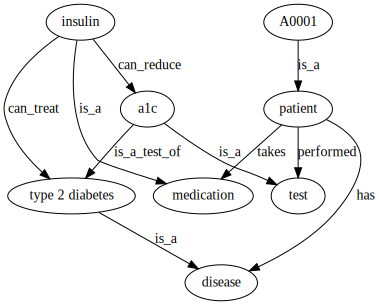



KNOWLEDGE GRAPH FOR PATIENT ID B0021:



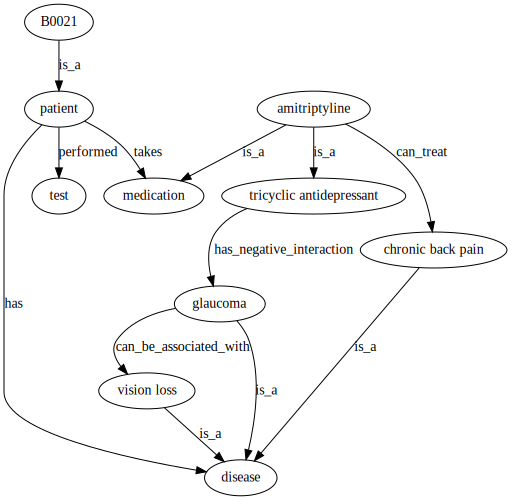



KNOWLEDGE GRAPH FOR PATIENT ID CA091:



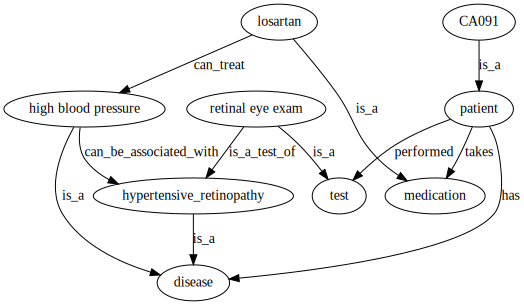

In [42]:
for patient_facts in entities:
    print (f"KNOWLEDGE GRAPH FOR PATIENT ID {patient_facts[0]}:\n")
    g = get_knowledge_graph(patient_facts, triple_store)
    display(g)
    g.render(f'graph_outputs/{patient_facts[0]}_graph.gv', view=True)  
    print ("\n ====================================== \n")